In [1]:
import pandas as pd
import statsmodels.api as sm
from scipy import interpolate
from pandas import Series, DataFrame, Panel
from string import ascii_lowercase as letters
from scipy.stats import chisqprob
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from scipy.stats import wrapcauchy
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
plt.style.use('classic')
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
np.random.seed(1234)

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def rw2(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
    return(x,y)   
    
n=10000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
data = rw2(n)
x=data[0]
y=data[1]
t=range(0,n)

In [3]:
# average distance
def rw2_distance(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    distance=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
        distance[i]=(x[i]**2+y[i]**2)**0.5
    return distance 
    
n=10000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
data_distance = rw2_distance(n)
t=range(0,n)
#data_distance

In [4]:
number_of_simulations=300# this is the number of rows or row vectors
#n=10000# number of columns or number of elements in that row vector
average_distances=np.zeros((number_of_simulations,n))
for i in range(number_of_simulations):
    average_distances[i]=rw2_distance(n)


In [5]:
matrix=np.zeros((2,5))# 2 rows 5 columns
matrix[1]=range(0,5)
matrix[0]=range(5,10)
print(matrix)
print(matrix.mean(axis=0))

[[ 5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.]]
[ 2.5  3.5  4.5  5.5  6.5]


In [6]:
# the mean average distance after 1 step, 2 steps, etc...

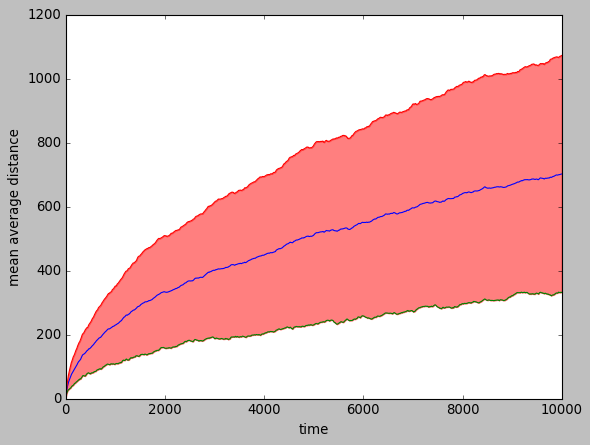

In [7]:
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
plt.plot(t,u)
plt.fill_between(t, u-error, u+error,color='red',alpha=0.5)
plt.plot(t,u-error)
plt.plot(t,u+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

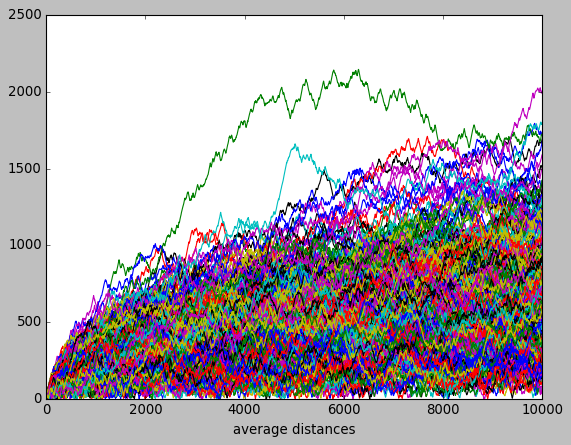

In [8]:
plt.plot(average_distances.T)
plt.xlabel('time')
plt.xlabel('average distances')
plt.show()

In [9]:
#y_log=np.log(y)#starts from zero
#x_original=np.log(t)
#linear function
#c_original=y_log-0.5*x
#D_original=0.5*np.exp(2*c_original)
#print(D)
#D_coefficient=np.mean(D[1:])
#D_coefficient

In [10]:
#not fine since D is supposed to be a number
 #the mean diffusion coefficient for the original data
#mean_D_original=np.zeros(len(t))  # skip zeros
#for i in range(len(mean_D_original)):
 #   mean_D_original[i]=(y[i]**2)/(2*t[i])
#mean_D_original=mean_D_original[1:] #get rid of the nan because vectors start from zero 
#mean_D_original_coefficient=np.mean(mean_D_original)
#mean_D_original_coefficient

In [11]:
D=u**2/(2*np.array(t))
D_from_1=D[1:]
D_coeff=np.mean(D_from_1[5000:])
D_coeff

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


25.3494

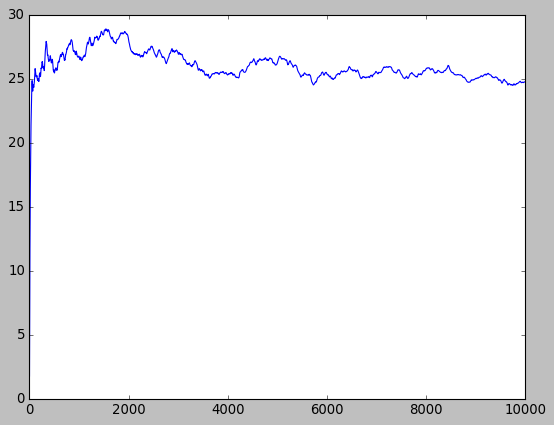

In [12]:
plt.plot(t,D)

In [13]:
# Now put them into the MCMC sampler, the second model is to be considered
import scipy.stats 
from scipy.stats import dweibull
def log_likelihood(x,a,b):# a is shape, b is scale
     return sum(dweibull.logpdf(x,scale=b,c=a))
def log_wclikelihood(x,a,b):
     return sum(wrapcauchy.logpdf(x,c=a,loc=b))# c is the shape parameter

In [14]:
#time_step=0.1
# my code pretty much starts here
time_step=0.1
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [15]:
x_new=f(t_new)
y_new=g(t_new)

In [16]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

99989
99989
99989
99988
99988


In [17]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.0005 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3504


0.983000844381
0.983864374306
19001


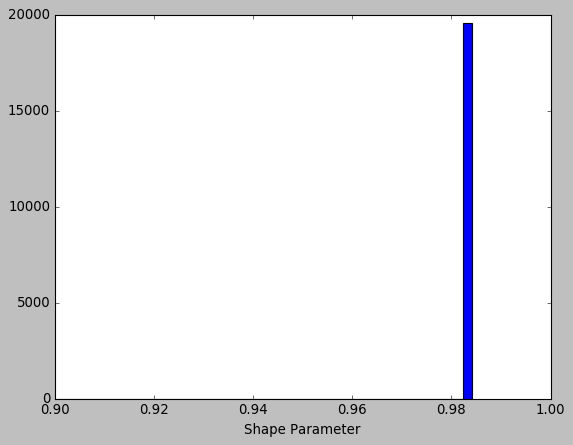

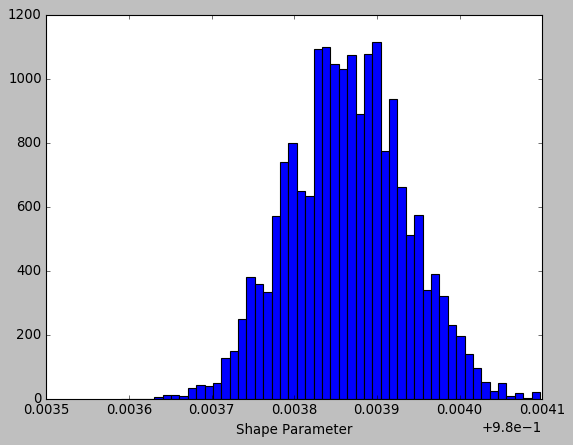

In [18]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
B1=np.array(A1[1000:])
print(len(B1))
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()

In [19]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.0015,0.0015]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3765


20001
4.39468332061
0.202206741685


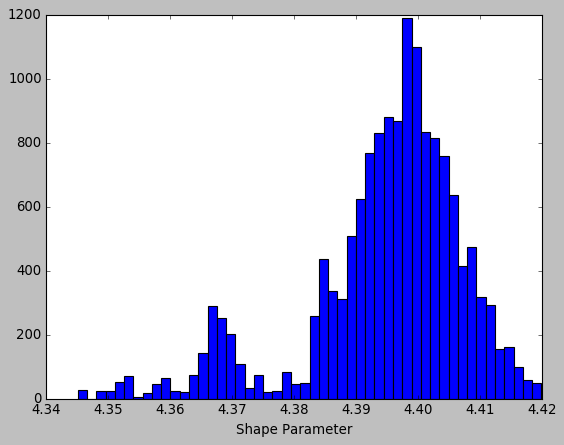

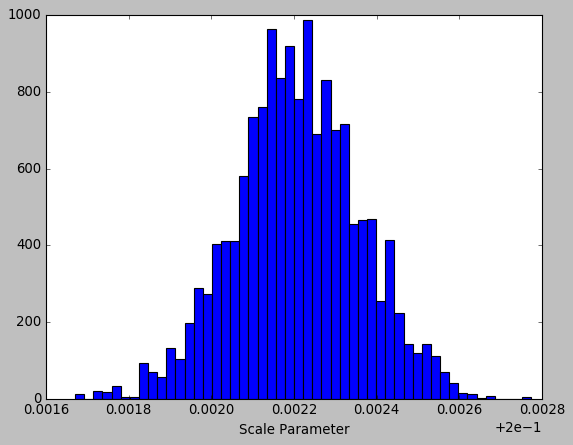

In [20]:
print(len(A2))
B2=np.array(A2[5000:])#burn-in 1000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)# now changing the parameters and n with the ones that I got
plt.xlabel("Scale Parameter")
plt.show()# now changing the parameters and n with the ones that I got



In [21]:
# I need the mean diffusion coefficient for the new data
# calculating the distance from the origin in the new data
# this is just for one sample
distance_origin_new_data=np.zeros(len(x_new))
distance_origin_new_data=(x_new**2+y_new**2)**0.5

In [22]:
number_new_simulations=300
average_new_data_distances=np.zeros((number_new_simulations,len(x_new)))

In [23]:
for i in range(number_new_simulations):
                               data=rw2(n)
                               x=data[0]
                               y=data[1]
                               t_new=np.arange(0,n-1,time_step)
                               f=interpolate.interp1d(t,x,kind='cubic')
                               g=interpolate.interp1d(t,y,kind='cubic')
                               x_new=f(t_new)
                               y_new=g(t_new)
                               distance_origin_new_data=np.zeros(len(x_new))
                               distance_origin_new_data=(x_new**2+y_new**2)**0.5# this becomes the first row and so on of the matrix
                               average_new_data_distances[i,]=distance_origin_new_data

In [24]:
y_new_data=average_new_data_distances.mean(axis=0)

In [25]:
#not fine since D is supposed to be a number
 #the mean diffusion coefficient for the original data
time_1000=t_new[:1000]   # I get the first 1000 observations 
mean_D_new_data=np.zeros(1000)#len(t_new[1:]))  # skip zeros # I put 1000 because I have 1000 below
for i in range(len(mean_D_new_data)):
    mean_D_new_data[i]=(y_new_data[i]**2)/(2*time_1000[i])
#mean_D_new_data=mean_D_new_data[1:] #get rid of the nan because vectors start from zero 
mean_D_new_data_coefficient=np.mean(mean_D_new_data[800:])
#print(mean_D_new_data)
print(len(mean_D_new_data))
print(mean_D_new_data_coefficient)


1000
23.0392375828


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [26]:
#y_new_data[-1]#gives me the last entry
#t_new[-1000:][::-1]# the last 1000 entries from big to small

In [27]:
# I need the mean diffusion coefficient for the data generated by the parameters obtained from inference

In [28]:
# Weibull
shape_parameters=B2[:,0]
scale_parameters=B2[:,1]
# select every 10th observation
shape_parameters_need=shape_parameters[::10][:-1301]# same length now
scale_parameters_need=scale_parameters[::10][:-1301]
#Wrapped Cauchy
shapewc_parameters=B1
shapewc_parameters_need=B1[::10][:-1701]
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))

200
200
200


In [29]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change,alpha_change,beta_change,c_change):# this gives samples from the inference model
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=np.zeros(n_change)
    distance_origin=np.zeros(n_change)
    distance=np.zeros(n_change)
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance_origin[i]=(x_change[i]**2+y_change[i]**2)**0.5
        distance[i]=r
    return [x_change,y_change,distance,theta,distance_origin]   
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_parameters_need#int(input("what's the scale?"))
beta_change=shape_parameters_need #int(input("what's the shape?"))
c_change=shapewc_parameters_need# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
#x_change = np.array(rw2_change(n_change)[0])
#y_change=np.array(rw2_change(n_change)[1])
#data_change=np.array(rw2_change(n_change)[2])
#theta_change=np.array(rw2_change(n_change)[3])
#the previous code

In [30]:
#print(scale_parameters_need)
#print(shape_parameters_need)
#print(shapewc_parameters_need)
print(n_change)


99988


In [31]:
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))
#make them the same size, check again

200
200
200


In [32]:
length_datas=1000

In [33]:
data_change=np.zeros((len(shape_parameters_need),length_datas))
theta_change=np.zeros((len(shapewc_parameters_need),length_datas))
# do arrays, matrices

In [34]:
print(len(alpha_change))
print(len(shape_parameters_need))
print(length_datas)
print(len(beta_change))
print(len(c_change))
hello=np.array(rw2_change(length_datas,alpha_change[1],beta_change[1],c_change[1])[2])
print(len(np.array(rw2_change(length_datas,alpha_change[1],beta_change[1],c_change[1])[2])))
print(len(np.array(rw2_change(length_datas,alpha_change[1],beta_change[1],c_change[1])[4])))
# works now

200
200
1000
200
200
1000
1000


In [35]:
count=0
for i in range(len(hello)-1):
    if hello[i]==0:
        count+=1
count        
# works now

1

In [36]:
#if you want to make them the same size
print(len(theta_change))
#print(len(theta_original))
#print(len(r_original))
print(len(data_change))
#Let's go to 999 then
#theta_change=theta_change[:999]
#theta_original=theta_original[:999]
#data_change=data_change[:999]
#shape_parameters_need=shape_parameters_need[:999]
#scale_parameters_need=scale_parameters_need[:999]
#shapewc_parameters_need=shapewc_parameters_need[:999]

200
200


In [37]:
# mistake here should be without -1
for i in range(len(shape_parameters_need)):
                     data_change[i,]=np.array(rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[2])#the distances

In [38]:
for i in range(len(shape_parameters_need)):
                     theta_change[i,]=np.array(rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[3])#the angles

In [39]:
#theta_change[1299] again zeros
#data_change[1299] zeros again

In [40]:
up=5
check=np.zeros(5)
length=len(check)
for i in range(0,length):
    check[i]=i+1
check    
# it's a mistake in here , should be len-1

array([ 1.,  2.,  3.,  4.,  5.])

In [41]:
# the mean of the inferred parameters
mean_shape_weibullparameter=np.mean(shape_parameters)
mean_scale_weibullparameter=np.mean(scale_parameters)
mean_shape_wcparameter=np.mean(shapewc_parameters)

In [42]:
# I need to find out the average D from 100 simulations for all the data that I've generated
# this is for 1 data, you need to do it for at least 200
# I need to create a matrix or a list to store my results
number_of_simulations=300
average_distances_change=np.zeros((number_of_simulations,length_datas))
y_change=np.zeros((len(shape_parameters_need),length_datas))
for i in range(len(shape_parameters_need)):
    for j in range(number_of_simulations):
        average_distances_change[j]=rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[4]
    y_change[i]=average_distances_change.mean(axis=0)
# for every set of parameters you run 100 times
# y_change is a matrix that stores on each row the <d> vectors for y_replicate

In [43]:
# calculating the D's the diffusion coefficients
time_1000=t_new[:1000]# the last 1000 observations in reverse order
mean_D_replicate=np.zeros((len(shape_parameters_need),length_datas))
mean_D_replicate_coefficient=np.zeros(len(shape_parameters_need))
for i in range(len(shape_parameters_need)):
    mean_D_replicate[i]=(y_change[i]**2)/(2*np.array(time_1000))# reverse order
    mean_D_replicate_coefficient[i]=np.mean(mean_D_replicate[i][800:])


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [44]:
y_change

array([[  0.    ,   0.183 ,   0.3613, ...,  55.0303,  55.0423,  55.0552],
       [  0.    ,   0.1853,   0.3635, ...,  57.9149,  57.9476,  57.9822],
       [  0.    ,   0.1851,   0.3628, ...,  56.9293,  56.9726,  57.0166],
       ..., 
       [  0.    ,   0.1821,   0.3704, ...,  57.3994,  57.434 ,  57.4713],
       [  0.    ,   0.1824,   0.3629, ...,  56.7007,  56.7294,  56.7593],
       [  0.    ,   0.1854,   0.371 , ...,  53.212 ,  53.2315,  53.2554]])

In [53]:
y_new_data[:1000]

array([  0.    ,   0.2069,   0.4039,   0.5935,   0.7785,   0.9602,
         1.1408,   1.3211,   1.5008,   1.6799,   1.8586,   2.037 ,
         2.215 ,   2.3926,   2.57  ,   2.7469,   2.9234,   3.0996,
         3.2754,   3.4505,   3.6246,   3.7974,   3.969 ,   4.1392,
         4.3079,   4.4751,   4.6406,   4.8043,   4.9661,   5.1258,
         5.2832,   5.4383,   5.5913,   5.7425,   5.8925,   6.0416,
         6.1901,   6.3385,   6.4869,   6.6354,   6.7843,   6.9336,
         7.0835,   7.2338,   7.3845,   7.5356,   7.6869,   7.8384,
         7.9898,   8.1412,   8.2924,   8.4432,   8.5939,   8.7445,
         8.8952,   9.0459,   9.1967,   9.3477,   9.4987,   9.6497,
         9.8007,   9.9518,  10.1027,  10.2535,  10.4039,  10.5538,
        10.7027,  10.8504,  10.9966,  11.1409,  11.2828,  11.4222,
        11.5593,  11.6943,  11.8277,  11.9597,  12.0905,  12.2205,
        12.3499,  12.4788,  12.6076,  12.7363,  12.8652,  12.9941,
        13.1232,  13.2524,  13.3816,  13.5107,  13.6395,  13.7

In [46]:
#y_change[1][::-1]# to have the vector in reverse order because the time is in reverse order
#time_1000=t_new[-1000:][::-1]
#time_1000

In [47]:
# compare the test statistics
T_y=mean_D_new_data_coefficient
T_y_rep=mean_D_replicate_coefficient


In [48]:
T_y

23.0392

In [49]:
T_y_rep

array([ 15.471 ,  16.8556,  15.9606,  15.3836,  17.0464,  14.3503,
        16.1945,  14.8324,  17.1549,  17.1976,  14.4896,  15.7036,
        15.4268,  17.1576,  17.1489,  16.228 ,  16.057 ,  15.6225,
        14.6023,  16.6511,  15.363 ,  16.2644,  15.221 ,  14.912 ,
        15.8124,  15.5058,  15.0699,  15.1806,  16.8958,  14.5459,
        15.4627,  13.5605,  14.8381,  15.6151,  15.5712,  14.9739,
        16.0942,  15.7706,  17.3023,  15.9723,  16.8251,  15.0323,
        16.216 ,  14.9034,  15.7325,  16.271 ,  17.1305,  16.4906,
        15.3018,  15.273 ,  16.0937,  14.8717,  15.8825,  15.145 ,
        14.8578,  17.3205,  16.3161,  14.9042,  16.1677,  16.36  ,
        14.7669,  15.3953,  16.1377,  15.8793,  13.5975,  15.6243,
        17.7552,  15.118 ,  15.003 ,  14.1099,  14.9961,  15.244 ,
        15.5297,  16.7214,  16.868 ,  16.3273,  15.9906,  16.0028,
        15.5897,  15.0627,  15.7374,  15.3887,  15.1929,  14.3539,
        15.7028,  15.7796,  15.816 ,  16.4496,  15.3545,  15.1

In [50]:
count=0
for i in range(len(shape_parameters_need)):
    if T_y_rep[i]>T_y:
        count+=1
print(count)
print(len(shape_parameters_need))
ppp_value=count/len(shape_parameters_need)
print(ppp_value)


0
200
0.0


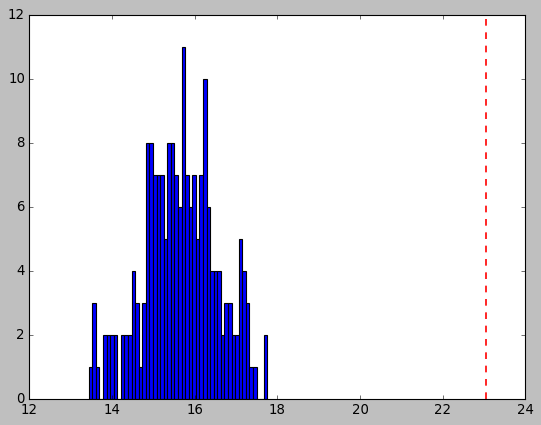

In [51]:
plt.hist(T_y_rep,bins=50)
plt.axvline(T_y,linestyle='dashed', linewidth=1.5,color='red')
plt.show()


In [52]:
u=[1,2,3]
v=[4,5,6]
np.array(u)/np.array(v)

array([ 0.25,  0.4 ,  0.5 ])

Text(0,0.5,'Diffusion coefficient')

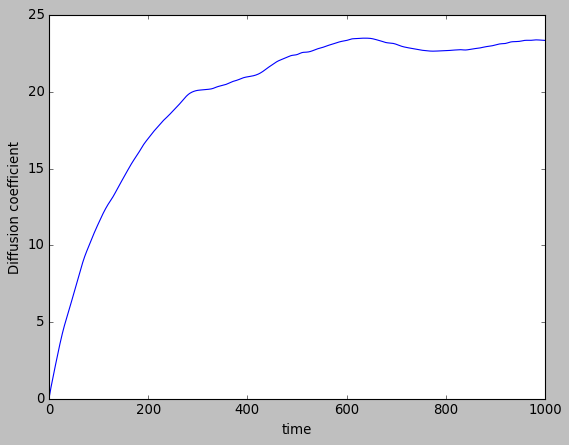

In [56]:
plt.plot(mean_D_new_data)
plt.xlabel('Time')
plt.ylabel('Diffusion coefficient')

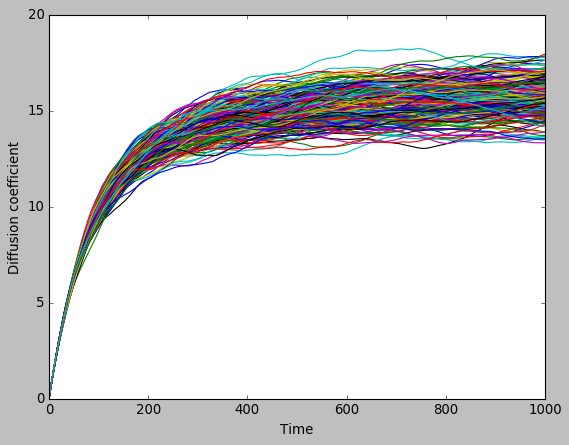

In [63]:
plt.plot(mean_D_replicate.T)
plt.xlabel('Time')
plt.ylabel('Diffusion coefficient')
plt.show()